# 构建自定义RAG智能体  
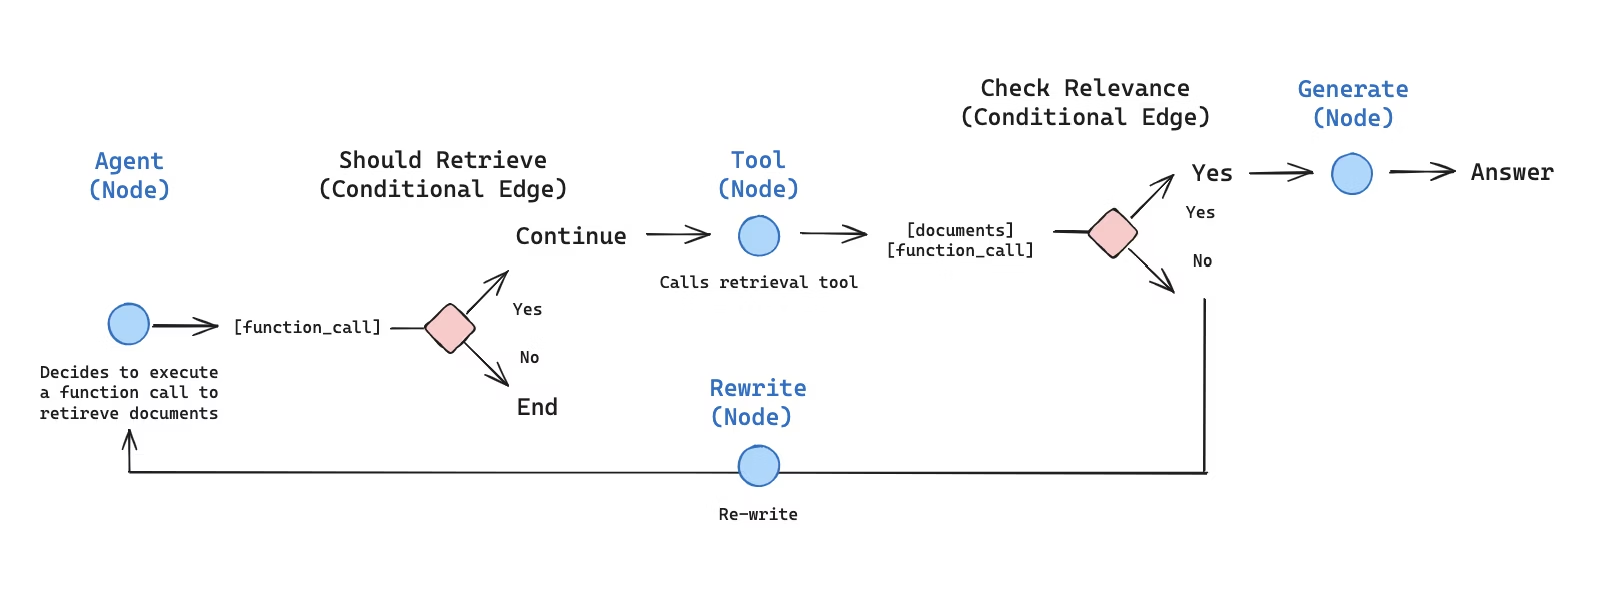  
## 1. 处理文档
### 获取文档

In [1]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs

USER_AGENT environment variable not set, consider setting it to identify your requests.


[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use

### 观察Document类

In [2]:
type(docs), type(docs[0]), type(docs[0][0]), len(docs), len(docs[0])

(list, list, langchain_core.documents.base.Document, 3, 1)

In [3]:
docs[0][0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use c

In [4]:
docs[0][0].model_dump().keys(), docs[0][0].model_dump()["metadata"].keys(), \
docs[0][0].to_json().keys(), docs[0][0].to_json()["kwargs"].keys()
        

(dict_keys(['id', 'metadata', 'page_content', 'type']),
 dict_keys(['source', 'title', 'description', 'language']),
 dict_keys(['lc', 'type', 'id', 'kwargs']),
 dict_keys(['metadata', 'page_content', 'type']))

In [5]:
docs[0][0].to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'document', 'Document'],
 'kwargs': {'metadata': {'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/',
   'title': "Reward Hacking in Reinforcement Learning | Lil'Log",
   'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty 

In [6]:
docs[0][0].model_dump()

{'id': None,
 'metadata': {'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/',
  'title': "Reward Hacking in Reinforcement Learning | Lil'Log",
  'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more auto

In [7]:
docs[1][0].page_content.strip()[200:1000]

' in LLMs\n    \nDate: July 7, 2024  |  Estimated Reading Time: 29 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nWhat Causes Hallucinations?\n\nPre-training Data Issues\n\nFine-tuning New Knowledge\n\n\nHallucination Detection\n\nRetrieval-Augmented Evaluation\n\nSampling-Based Detection\n\nCalibration of Unknown Knowledge\n\nIndirect Query\n\n\nAnti-Hallucination Methods\n\nRAG → Edits and Attribution\n\nChain of Actions\n\nSampling Methods\n\nFine-tuning for Factuality\n\nFine-tuning for Attribution\n\n\nAppendix: Evaluation Benchmarks\n\nCitation\n\nReferences\n\n\n\n\n\nHallucination in large language models usually refers to the model generating unfaithful, fabricated, inconsistent, or nonsensical content. As a term, hallucination has been somewhat generalized to cases when the model makes mistakes. Here, I would like '

### 将获取的文档分割成更小的块，以便索引到向量存储中

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]
print(docs_list)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use 

In [9]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,
    chunk_overlap=50,
)
doc_splits = text_splitter.split_documents(docs_list)
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use 

In [10]:
doc_splits[0].page_content

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

## 2.创建检索工具
### 使用in-memory向量库存储

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore
from utils import SiliconFlowEmbeddings

embedding = SiliconFlowEmbeddings(
    model="BAAI/bge-m3",
)

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

### 使用LangChain预置的create_retriever_tool创建检索工具

In [12]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="检索博客文章",
    description="搜索并返回有关翁荔博客文章的信息。"
)
# 测试工具
retriever_tool.invoke({"query": "在强化学习中，奖励作弊是什么？"})

'It is noteworthy that even after the curriculum, the model overwrote the reward and avoided detection less than 1/1000 of the time. Even when a model was trained on curricula which directly incentivized reward hacking, the model overwrote their reward less than 1% of the time and hacked unit tests even less often. As a simple mitigation, supervised fine-tuning the model on the first two environments–where the reward hacking behavior is easy to be detected (sycophancy and\n\nHacking RLHF of LLMs#\nReinforcement learning from human feedback (RLHF) has become the de facto approach for alignment training of language models. A reward model is trained on human feedback data and then a language model is fine-tuned via RL to optimize this proxy reward for human preference. There are three types of reward we care about in an RLHF setup:\n\nReward shaping is a technique used to enrich the reward function, making it easier for the agent to learn—for example, by providing denser rewards. However,

## 3.生成查询query

In [13]:
from langgraph.graph import MessagesState
from utils import llm_modelscope

def generate_query_or_respond(state: MessagesState):
    model = llm_modelscope(model="Qwen/Qwen3-30B-A3B-Instruct-2507")
    response = model.bind_tools(tools=[retriever_tool]).invoke(state["messages"])
    
    return {"messages": [response]}

In [14]:
# 用随机输入测试
input = {"messages": [{"role": "user", "content": "你好，忧愁？"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()


================================== Ai Message ==================================

你好！看起来你可能有些心事。如果你愿意，可以和我聊聊，我会尽力倾听并提供帮助。


In [15]:
# 需要语义搜索的问题
input = {
    "messages": [
        {
            "role": "user",
            "content": "Lilian Weng关于reward hacking都说了些什么？请用中文回答问题。"
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  检索博客文章 (call_8726b71c36c14547b7b00c)
 Call ID: call_8726b71c36c14547b7b00c
  Args:
    query: Lilian Weng reward hacking


## 4.给文档评分
添加一个条件边：grade_documents，来判断检索到的文档是否与问题相关。我们将使用一个具有结构化输出模式GradeDocuments的模型来进行文档评分。grade_documents函数将根据评分决定返回要前往的节点名称（generate_answer或rewrite_question）。

In [28]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = """你是一名评分员，负责评估检索到的文档与用户问题的相关性。\n
以下是检索到的文档：\n\n{context}\n\n
以下是用户的问题：{question}\n
如果该文档包含与用户问题相关的关键词或语义，就将其评为相关。\n
给出"是"或"否"的二元评分，以表明该文档与问题是否相关。

重要：请以 JSON 格式返回结果，包含以下字段：
- binary_score: "是" 或 "否"
"""

class GradeDocuments(BaseModel):
    """使用二元分数对文档进行评分，以检查相关性。"""
    binary_score: str=Field(default="否", description="相关性分数：如果相关则为“是”，如果不相关则为“否”")
    

def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    """决定检索到的文档是否和问题相关"""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    
    prompt = GRADE_PROMPT.format(question=question, context=context)
    grader_model = llm_modelscope(model="Qwen/Qwen3-30B-A3B-Instruct-2507", temperature=0)
    response = grader_model.with_structured_output(GradeDocuments).\
        invoke([{"role": "user", "content": prompt}])
    score = response.binary_score
    
    if score == "是":
        return "generate_answer"
    else:
        return "rewrite_question"

In [29]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Lilian Weng关于reward hacking都说了些什么？请用中文回答问题。",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "检索博客文章",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

## 5.重写问题
构建rewrite_question节点。检索工具可能会返回潜在的不相关文档，这表明需要改进原始的用户问题。为了做到这一点，我们将调用rewrite_question节点

In [30]:
from langchain_core.messages import HumanMessage

REWRITE_PROMPT = """查看输入并尝试推断其潜在的语义意图或含义。
以下是初始问题：
<initial_question>
{question}
</initial_question>
依据初始问题的潜在语义意图改写一个新问题，以便到向量数据库中检索相关信息，用于回答问题。"""

def rewrite_question(state: MessagesState):
    """重写用户的初始问题"""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    model = llm_modelscope(model="Qwen/Qwen3-30B-A3B-Instruct-2507")
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [24]:

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Lilian Weng关于reward hacking都说了些什么？请用中文回答问题。",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "检索博客文章",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
response = rewrite_question(input)
response["messages"][-1].content

'Lilian Weng 对 reward hacking 的相关论述有哪些？'

## 6.生成问题
构建`生成答案节点`，如果我们通过了评分器检查，就可以根据原始问题和检索到的上下文生成最终答案。

In [31]:
GENERATE_PROMPT = """你是一个问答任务助手。
使用以下检索到的上下文片段来回答问题。
如果你不知道答案，只需说你不知道。
最多使用三句话，保持答案简洁。\n
问题：{question} \n
上下文：{context}"""

def generate_answer(state: MessagesState):
    """生成答案"""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    model = llm_modelscope(model="Qwen/Qwen3-30B-A3B-Instruct-2507")
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [32]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Lilian Weng关于reward hacking都说了些什么？请用中文回答问题。",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "检索博客文章",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng指出，reward hacking可分为两类：环境或目标设定不准确，以及奖励篡改。


## 7.组装图
现在将所有节点和边组合成一个完整的图：  
从`generate_query_or_respond`开始，并确定我们是否需要调用`retriever_tool`
使用`tools_condition`路由到下一步：  
- 如果`generate_query_or_respond`返回了`tool_calls`，调用`retriever_tool`来获取上下文。  
- 否则，直接对用户做出回应。  

对检索到的文档内容与问题的相关性进行评分（`grade_documents`），并路由到下一步：  
- 如果不相关，使用`rewrite_question`重写问题，然后再次调用`generate_query_or_respond`
- 如果相关，继续执行`generate_answer`，并使用包含检索到的文档上下文的`ToolMessage`生成最终回应

In [33]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")
workflow.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")
graph = workflow.compile()

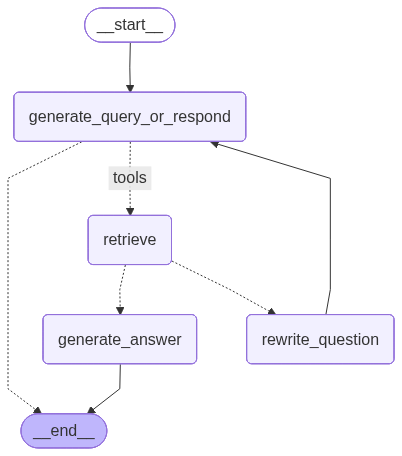

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 8.运行Agentic RAG

In [35]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Lilian Weng关于reward hacking都说了些什么？请用中文回答问题。",
            },
        ],
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  检索博客文章 (call_2b455706dbfa47cf83318a)
 Call ID: call_2b455706dbfa47cf83318a
  Args:
    query: Lilian Weng reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: 检索博客文章

Citation#
Cited as:

Weng, Lilian. “Reward Hacking in Reinforcement Learning”. Lil’Log (Nov 2024). https://lilianweng.github.io/posts/2024-11-28-reward-hacking/.

author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Nov",
  url     = "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/"
}
References#

Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      Reward Hacking in Reinforcement Learning
    
Date: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng

Or
@article{weng2024rewardhack,
  titl